# **Tensor-Train Thermo-Field Dynamics (TT-TFD) Tutorial**

Developed by Ningyi Lyu (ningyi.lyu@yale.edu)

Based on ["Tensor-Train Thermo-Field Memory Kernels for Generalized Quantum Master Equations"](https://arxiv.org/abs/2208.14273) by Ningyi Lyu, Ellen Mulvihill, Micheline B. Soley, Eitan Geva, Victor S. Batista

## **1. Connecting to Google Drive**

This section is required if running in Google Collab, otherwise it is unnecessary.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/mydir')
os.chdir('/content/mydir/MyDrive/GQME_Tutorial')


Mounted at /content/mydir


# **III. Importing Libraries**

## **III.i Installing and Importing Tensor-Train Libraries**

The tensor-train library, `ttpy`, must be on your computer before this code can work Which is done in the first line.

In [1]:
!pip install git+https://github.com/bcallen95/ttpy.git --quiet

import tt
import tt.ksl

## **III.ii Importing Other Libraries**

In [2]:
import sys, os

import numpy as np
import math
from scipy import interpolate
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.style.use('classic')
from functions import *

# **IV. General Functions**

These functions are used in multiple sections of the code, so they are put at the beginning.

## **IV.iii Class to Suppress KSL Output**

In [3]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in Python, i.e. will suppress all print, even if the print originates in a compiled C/Fortran sub-function.
    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds =  [os.open(os.devnull,os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0],1)
        os.dup2(self.null_fds[1],2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0],1)
        os.dup2(self.save_fds[1],2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

# **1. Calculating the Time Evolution Superoperator ${\cal U}(\tau)$**

This section calculates the time evolution superoperator ${\cal U}(\tau)$ using the TT-TFD method. For the spin-boson model, ${\cal U}(\tau)$ has 16 elements.

## **1.1 Constants and Global Variables**

$\quad$ This subsection defines the constants and global variables used within the calculation of the time evolution superoperator ${\cal U}(\tau)$.

In [4]:
# general constants
TIME_STEPS = 2000 # number of time steps
tau = 5              # propagation time step
au2ps = 0.00002418884254 # Conversion of attoseconds to atomic units
timeau = 12.409275
DT = tau * au2ps * timeau # time step in au
FINAL_TIME = TIME_STEPS * DT # final time
DOF_E = 2 # number of electronic states
DOF_E_SQ = DOF_E * DOF_E
DOF_N = 60 # number of nuclear DOF

MODEL_NUM = 2 # model number

# matrix for U from TT-TFD
U = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
# matrix for U after calculating coherences
U_final = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

# TT-TFD constants
eps = 1e-14            # tt approx error
rma = 2000000                # max tt rank
dim = DOF_N         # number of coords
occ = 10                 # maximum occupation number; low for harmonic systems
EYE = 1j
au = 3.00166 * 10**(-4) # atomic units
cmn1toau = 4.5563353e-6 # Conversion of wavenumbers to atomic units

# setting parameters that based on the model number
BETA = 5 # inverse finite temperature beta = 1 / (k_B * T)
GAMMA_DA = 1 # diabatic coupling
if MODEL_NUM == 1:
    EPSILON = 1    # half of the energy gap between the donor and acceptor
    XI = 0.1       # friction coefficient, determines strength of e-n coupling
    OMEGA_C = 1    # cutoff frequency of the nuclear DOF
    OMEGA_MAX = 5  # maximum frequency of the nuclear DOF
elif MODEL_NUM == 2:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 3:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 7.5
    OMEGA_MAX = 36
elif MODEL_NUM == 4:
    EPSILON = 1
    XI = 0.4
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 6:
    EPSILON = 0
    XI = 0.2
    OMEGA_C = 2.5
    OMEGA_MAX = 12

# bath constants
om = OMEGA_C * au / DOF_N * (1 - np.exp(-OMEGA_MAX/OMEGA_C))
lam = 20. * cmn1toau
alpha = lam / (2 * OMEGA_C * au * np.pi)

print("        model # =", MODEL_NUM)
print("     time steps =", TIME_STEPS)
print("             DT =", DT)
print("     final time =", FINAL_TIME)
print("          DOF_E =", DOF_E)
print("          DOF_N =", DOF_N)
print("        epsilon =", EPSILON)
print("             xi =", XI)
print("        omega_c =", OMEGA_C)
print("      omega_max =", OMEGA_MAX)

        model # = 2
     time steps = 2000
             DT = 0.0015008299950527925
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 60
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10


## **1.2 Calculation of ${\cal U}(\tau)$ elements via TT-TFD**

In this subsection, we introduce the TT-TFD method, which simulates high-dimensional wavepacket dynamics with finite temperature. The code below describes the population dynamics of a 2-level spin-boson model.

The Hamiltonian in Eq. (14) can also be written:

$$H=\epsilon\hat\sigma_z+\Gamma\hat\sigma_x+\sum_{k = 1}^{N_n}\omega_k \hat a_k^\dagger a_k+\hat\sigma_z\sum_{k = 1}^{N_n} g_k(\hat a_k^\dagger+\hat a_k),$$

where $a_k^\dagger$ and $a_k$ are the creation and annihilation operators of the nuclear DOF, respectively, and $g_k = -\dfrac{c_k}{\sqrt{2\omega_k}}$ is responsible for the linear coupling between the electronic sites and the bath modes.

The frequencies $\omega_k$ are discretized as:
$$\omega_k=-\omega_c\text{log}\bigg(1-k\dfrac{\Omega}{\omega_c}\bigg),$$
where $\Omega=(1-e^{-\omega_{max}/\omega_c})\omega_c/N_n$ and $\omega_{max}$ is the maximum frequency.

The linear coupling constant $g_k$ is related to the spectral density function, which, when taken the Ohmic form, results in:

$$g_k=-\sqrt{\xi\omega_i\Omega/2}.$$


### **1.2.1 Nuclear mode arrays**

In [5]:
# initialize arrays for parameters
freq = np.zeros((DOF_N)) # frequency
ck = np.zeros((DOF_N))   # linear electron-phonon coupling constant
gk = np.zeros((DOF_N))   # ck in occupation number representation
thetak = np.zeros((DOF_N)) # temperature-dependent mixing parameter in TFD
sinhthetak = np.zeros((DOF_N)) # sinh(theta)
coshthetak = np.zeros((DOF_N)) # cosh(theta)
for i in range(DOF_N):
    freq[i] = -OMEGA_C * au * np.log(1-(i+1) * om/(OMEGA_C * au)) # Ohmic frequency
    ck[i] = np.sqrt(XI * om) * freq[i] #Ohmic coupling constant
    gk[i] = -ck[i] / np.sqrt(2 * freq[i]) #Transfer ck to occ. num. representation
    thetak[i] = np.arctanh(np.exp(-BETA/au * freq[i]/2)) #theta, defined for harmonic models
    sinhthetak[i] = np.sinh(thetak[i]) #sinh(theta)
    coshthetak[i] = np.cosh(thetak[i]) #cosh(theta)

### **1.2.2 Initial State**

The Thermo Field Dynamics method solves the thermal Schrodinger equation:

$$\frac{\partial|\Psi(t,\beta)\rangle}{\partial t}=-i\bar{H}|\Psi(t,\beta)\rangle,$$

where the initial temperature dependent wavepacket $\Psi(0,\beta)$ correspond to the thermally averaged density matrix:
$$|\Psi(0,\beta)\rangle\langle\Psi(0,\beta)|=Z^{-1}e^{-\beta H}.$$

It has been shown that such a $|\Psi(0,\beta)\rangle$ is only possible in the double space, that is, the composite Hilbert space $\cal{H}_s\otimes\tilde{\cal{H}}_s$, where $\cal{H}_s$ is the physical Hilbert space, and $\tilde{\cal{H}}_s$ is a duplicate of $\cal{H}_s$ in the sense that if $\cal{H}_s$ is spanned by energy eigenvectors $\{|n\rangle\}$ where $H|n\rangle=E_n|n\rangle$, then $\tilde{\cal{H}}_s$ is spanned by $\{|\tilde{n}\rangle\}$ with the same set of energy eigenvalues for a duplicate Hamiltonian $\tilde{H}$: $\tilde{H}|n\rangle=E_n|\tilde{n}\rangle$.

Moreover, it has been shown that $|\Psi(0,\beta)\rangle$ could be obtained by a unitary rotation of the double space ground state $|0,\tilde{0}\rangle$:

$|\Psi(0,\beta)\rangle=e^{-iG}|0,\tilde{0}⟩$,

where for a harmonic system like the spin-boson model, $G=-i\sum_k^N\theta_k(a_k\tilde{a}_k-a_k^\dagger\tilde{a}_k^\dagger)$, $\theta_k=\text{arctanh}(e^{-\beta\omega_k/2})$.

The thermal Schrodinger equation is therefore transformed by $G$ to become an equation of motion which initial condition is the easily prepared $|0,\tilde{0}\rangle$:

$\frac{\partial|\Psi_\theta(t,\beta)\rangle}{\partial t}=-i\bar{H}_\theta|\Psi_\theta(t,\beta)\rangle$,
where $\bar{H}_\theta=e^{iG}\bar{H}e^{-iG}$, $|\Psi_\theta(0,\beta)\rangle=|0,\tilde{0}\rangle$.

We first show how this initial state $|\Psi_\theta(t,\beta)\rangle$ is constructed. In the code below, the arrays su and sd are for the electronic degree of freedom. For this particular setup, we initiate the wavepacket on the first electronic state, so su is used for tt_psi0, which is $|0,\tilde{0}\rangle$. Note that in this program, the Born-Oppenheimer seperation is always assumed, so the electronic degree of freedom does not use the double space formation. As for the vibrational bath modes, $2N_n$ vibrational degrees of freedom are appended using tt.kron, each in its ground state, represented by gs.

In [6]:
#Build initial ground state
su = np.array([1,0])
sd = np.array([0,1])
tt_su = tt.tensor(su)
tt_sd = tt.tensor(sd)
e1 = np.sqrt(0.5) * (su + sd)
e2 = np.sqrt(0.5) * (su + EYE * sd)
tt_e1 = tt.tensor(e1)
tt_e2 = tt.tensor(e2)
tt_Ie = tt.eye(2,1)
gs = np.zeros((occ))
gs[0] = 1.
tt_gs = tt.tensor(gs)
tt_psi0 = tt_su
for k in range(2 * DOF_N): # double space formation
    tt_psi0 = tt.kron(tt_psi0, tt_gs)

### **1.2.3 Constructing $\bar{H}_\theta$**

Next, we show how $\bar{H}_\theta$ is constructed. First, with the spin-boson Hamiltonian $H$, unitary transformation $G$, and thermal rotation angle $\theta_k$ defined previously, we have:

$$\bar{H}_\theta=\epsilon\hat\sigma_z + \Gamma\hat\sigma_x+\sum_{k = 1}^{N_n} \omega_k (\hat a_k^\dagger \hat a_k-\hat{\tilde{a}}_k^\dagger \hat{\tilde{a}}_k) + \hat\sigma_z\sum_{k = 1}^{N_n} g_k\text{cosh}(\theta_k)(\hat a_k^\dagger+ \hat a_k)+g_k\text{sinh}(\theta_k)(\hat{\tilde{a}}_k^\dagger + \hat{\tilde{a}}_k).$$

Below we explain how each term is constructed.

First, the electronic Hamiltonian $\epsilon\hat\sigma_z + \Gamma\hat\sigma_x$ is set as a 2-by-2 matrix, appended with identity matrices for bath degrees of freedom (both physical and tilde) to ensure consistency of overall dimensionality:

In [7]:
# constructing Pauli operators
px = np.array([[0,1],[1,0]])
pz = np.array([[1,0],[0,-1]])
# Build electronic site energy matrix
He = EPSILON * au * pz + GAMMA_DA * au * px
# TT-ize that energy matrix
tt_He = tt.matrix(He)
tt_He = tt.kron(tt_He, tt.eye(occ, DOF_N * 2))

Then, the physical harmonic Hamiltonian $\sum\limits_{k = 1}^{N_n}\omega_k \hat a_k^\dagger \hat a_k$ is constructed as a sum over N direct product states, each state with its $k^{th}$ core corresponding to the $k^{th}$ number operator ($\hat a_k^\dagger \hat a_k$), and all other cores are identity matrices. After obtaining this sum of product physical harmonic operator, a 2-by-2 identity matrix (corresponding to the 2-state electronic site) is appended before, and $N_n$ identity matrices (corresponding to the $N_n$ fictitious bath modes) are appended in the back, to ensure the overall dimensionality is correct:

In [8]:
# Build number operator, corresponds to harmonic oscillator Hamiltonian
numoc = np.diag(np.arange(0, occ, 1))
# Initiate the TT-ized number operator as a zero TT array with shape of occ^N
tt_numoc = tt.eye(occ, DOF_N)*0.
# Construct number operator as TT
for k in range(DOF_N):
    if k == 0:
        tmp = tt.kron(tt.matrix(numoc) * freq[k], tt.eye(occ, DOF_N - 1))
    elif 0 < k < DOF_N-1:
        tmp = tt.kron(tt.eye(occ,k-1), tt.matrix(numoc) * freq[k])
        tmp = tt.kron(tmp,tt.eye(occ, DOF_N - k))
    else:
        tmp = tt.kron(tt.eye(occ,k), tt.matrix(numoc) * freq[k])
    tt_numoc = tt_numoc + tmp
    tt_numoc = tt_numoc.round(eps)
# Ensure correct dimensionality
tt_Ie = tt.eye(2,1)
tt_systemnumoc = tt.kron(tt_Ie, tt_numoc)
tt_systemnumoc = tt.kron(tt_systemnumoc, tt.eye(occ, DOF_N))

Note that in the above code, rounding after each iteration is essential for controlling the tensor train rank.

Since the ficticious system is merely a duplicate of the physical system, tt_numoc could be directly used for the construction of the ficticious harmonic hamiltonian $\sum\limits_{k = 1}^{N_n} \hat{\tilde{a}}_k^\dagger \hat{\tilde{a}}_k$. The only difference is in the last step, where both electronic and physical bath modes are appended in the front.

In [9]:
# create a duplicate of number operator for the ficticious system
tt_tildenumoc = tt.kron(tt_Ie, tt.eye(occ, DOF_N))
tt_tildenumoc = tt.kron(tt_tildenumoc, tt_numoc)

Next, we construct the displacement operator. First we would need to obtain the parameters related to the thermal rotation angle $\theta_k$, which are arrays of $\text{cosh}(\theta_k)$ and $\text{sinh}(\theta_k)$:

In [10]:
thetak = np.zeros((DOF_N)) #temperature-dependent mixing parameter in TFD
sinhthetak = np.zeros((DOF_N)) #sinh(theta)
coshthetak = np.zeros((DOF_N)) #cosh(theta)
for i in range(DOF_N):
    thetak[i] = np.arctanh(np.exp(-BETA/au * freq[i]/2)) #theta, defined for harmonic models
    sinhthetak[i] = np.sinh(thetak[i]) #sinh(theta)
    coshthetak[i] = np.cosh(thetak[i]) #cosh(theta)

Then, we construct a single mode displacement operator:

In [11]:
#Build displacement operator, corresponds to x operator in real space
eneroc = np.zeros((occ, occ))
for i in range(occ - 1):
    eneroc[i,i+1] = np.sqrt(i+1)
    eneroc[i+1,i] = eneroc[i,i+1]

With these, the physical displacement operator $\hat\sigma_z \sum\limits_{k = 1}^{N_n} g_k\text{cosh}(\theta_k)(\hat a_k^\dagger + \hat a_k)$ is constructed as sum of product with a process very similar to tt_numoc:

In [12]:
# initialize displacement operator
tt_energy = tt.eye(occ, DOF_N)*0.
for k in range(DOF_N):
    if k == 0:
        # coshtheta takes account for energy flow from real to ficticious system
        # thus takes account for temperature effect
        tmp = tt.kron(tt.matrix(eneroc) * gk[k] * coshthetak[k], tt.eye(occ, DOF_N - 1))
    elif 0 < k < DOF_N - 1:
        tmp = tt.kron(tt.eye(occ,k-1), tt.matrix(eneroc) * gk[k] * coshthetak[k])
        tmp = tt.kron(tmp,tt.eye(occ, DOF_N - k))
    else:
        tmp = tt.kron(tt.eye(occ,k), tt.matrix(eneroc) * gk[k] * coshthetak[k])
    tt_energy = tt_energy + tmp
    tt_energy = tt_energy.round(eps)

The only difference is that the electronic site appended in the front would be $\hat\sigma_z$ instead of identity matrix:

In [13]:
tt_systemenergy = tt.kron(tt.matrix(pz), tt_energy)
tt_systemenergy = tt.kron(tt_systemenergy, tt.eye(occ, DOF_N))

Now, for the tilde displacement operator $\hat\sigma_z\sum\limits_{k = 1}^{N_n} g_k\text{sinh}(\theta_k)(\hat{\tilde{a}}_k^\dagger + \hat{\tilde{a}}_k)$, both electronic pauli z matrix and identity matrices corresponding to the real bath DOF are appended in the front:

In [14]:
# initialize displacement operator
tt_tilenergy = tt.eye(occ, DOF_N)*0.
for k in range(DOF_N):
    if k == 0:
        tmp = tt.kron(tt.matrix(eneroc) * gk[k] * sinhthetak[k], tt.eye(occ, DOF_N - 1))
    elif 0 < k < DOF_N - 1:
        tmp = tt.kron(tt.eye(occ,k-1), tt.matrix(eneroc) * gk[k] * sinhthetak[k])
        tmp = tt.kron(tmp, tt.eye(occ, DOF_N - k))
    else:
        tmp = tt.kron(tt.eye(occ,k), tt.matrix(eneroc) * gk[k] * sinhthetak[k])
    tt_tilenergy = tt_tilenergy + tmp
    tt_tilenergy = tt_tilenergy.round(eps)
tt_tildeenergy = tt.kron(tt.matrix(pz), tt.eye(occ, DOF_N))
tt_tildeenergy = tt.kron(tt_tildeenergy, tt_tilenergy)

Now we obtain all components of $\bar{H}_\theta$, and we simply add them up and define $A=-i\bar{H}_\theta$, so the transformed thermal Schrodinger equation is written as $\dfrac{\partial|\Psi_\theta(t,\beta)\rangle}{\partial t}=A|\Psi_\theta(t,\beta)\rangle$, where $|\Psi_\theta(0,\beta)\rangle$ is constructed previously as tt_psi0. This is now a first-order equation of motion, with initial state and condition of motion explicitly given. Therefore, direct integration yields the updated state.

In [15]:
# Note that ficticious Harmonic oscillators carry negative sign
H = tt_He + tt_systemnumoc - tt_tildenumoc + tt_systemenergy + tt_tildeenergy
H = H.round(eps)
# Construct propagation operator, d/dt psi(t0)=A psi(t0)
A = -EYE * H

### **1.2.4 Noise for KSL**
The time-evolving state is called y0, which is initiated at tt_psi0. For the integration, TT-KSL algorithm is used. Since KSL is by construction a fixed-rank algorithm, we add a small (norm=10^-10), high-rank noise to carry out the propagation with a higher rank for improved accuracy:

In [16]:
y0 = tt_psi0 # initial wavepacket
# Add noise, for higher rank KSL propagation
radd = np.array([1,9]) # the rank of the first bath mode core is capped by occ
radd = np.append(radd, np.repeat(9, DOF_N * 2-3))
radd = np.append(radd, np.array([9,1])) # and the last core
tt_rand = tt.rand(occ, DOF_N * 2, radd) # random TT array with desired size and rank
tt_rand = tt_rand * tt_rand.norm()**(-1) # Renormalize noise
tt_rand = tt.kron(tt.ones(2,1), tt_rand)# Append electronic site
y0 = y0 + tt_rand * 1e-10 # Ensure noise is small

### **1.2.5 Output Arrays**
Prior to the propagation loop, we initialize several arrays for the desired output:

In [17]:
# Heaviside functions, for selecting electronic states from overall wavefunction
tt_heavu = tt.kron(tt_su,tt.ones(occ, dim*2))
tt_heavd = tt.kron(tt_sd,tt.ones(occ, dim*2))
# Propagation time step and range
t = np.arange(0, TIME_STEPS * tau, tau)
t = t * au2ps * timeau

In [18]:
# arrays to cut the wavepacket, to calculate coherences
ul = np.array([[1,0],[0,0]])
ur = np.array([[0,1],[0,0]])
tt_ul = tt.matrix(ul)
tt_ur = tt.matrix(ur)
for i in range(DOF_N * 2):
    tt_ul = tt.kron(tt_ul, tt.eye(occ,1))
    tt_ur = tt.kron(tt_ur, tt.eye(occ,1))

### **1.2.6 Propagation Starting in the Donor/Spin-Up State**

This subsection propagates with the initial state in spin-up. It should be noted that all the sections that do the propagation for different initial electronic states (Secs. 1.2.6, 1.2.7, 1.2.8, and 1.2.9) do not depend on each other and are usually run in parallel in practice.

It takes about 30 minutes to finish for 2000 time steps and $N_n = 60$.

In [19]:
# Propagation loop
for ii in range(TIME_STEPS):
    with suppress_stdout_stderr():
        y0 = tt.ksl.ksl(A, y0, tau)
    #print(t[ii])
    U[ii][0][0] = np.abs(tt.dot(tt_heavu * y0, tt_heavu * y0))
    U[ii][3][0] = np.abs(tt.dot(tt_heavd * y0, tt_heavd * y0))
    U[ii][2][0] = tt.dot(tt.matvec(tt_ul,y0), tt.matvec(tt_ur, y0))
    U[ii][1][0] = tt.dot(tt.matvec(tt_ur,y0), tt.matvec(tt_ul, y0))



#### **1.2.6.1 Plot of the population difference $\sigma_z(t)$ dynamics starting in the donor/spin-up state (optional)**
After the propagation, the population difference $\sigma_z(t) = \sigma_{00}(t) - \sigma_{11}(t)$ dynamics is plotted:

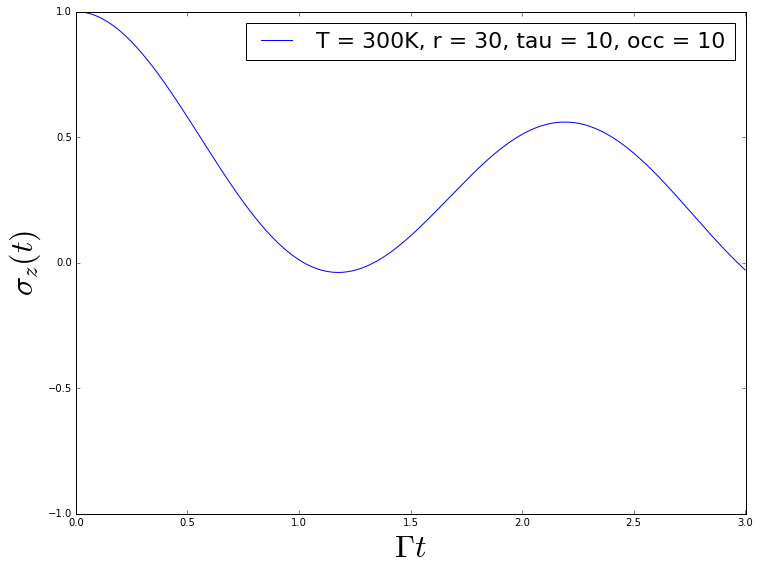

In [20]:
#Plot population difference
sigma_z = np.zeros((TIME_STEPS))
for i in range(TIME_STEPS):
    sigma_z[i] = U[i][0][0].real - U[i][3][0].real

plt.figure(figsize = (12,9))
plt.xlim(0.,FINAL_TIME)
plt.ylim(-1.,1.)
plt.xlabel(r'$\Gamma t$', fontsize = 32)
plt.ylabel(r'$\sigma_z(t)$', fontsize = 32)
plt.plot(t, sigma_z, label='T = 300K, r = 30, tau = 10, occ = 10')
plt.legend(fontsize = 22)

These are the results for U elements with the last two digits 00, which correspond to wavepacket dynamics that initiate at spin-up state. Next, initial states that correspond to spin-down state as well as states used to prepare coherent elements of U are constructed, and population and coherence is calculated in a manner analogus to the above calculation for spin-up initial state.

### **1.2.7  Propagation Starting in the Acceptor/Spin-Down State**

This subsection propagates with the initial state in spin-down.

It takes about 22 minutes to finish for 2000 time steps and $N_n = 60$.

In [21]:
tt_psi0 = tt_sd
for k in range(2 * DOF_N):#double space formation
    tt_psi0 = tt.kron(tt_psi0, tt_gs)
y0 = tt_psi0#initial wavepacket
#Add noise, for higher rank KSL propagation
radd = np.array([1,9])#the rank of the first bath mode core is capped by occ
radd = np.append(radd, np.repeat(9, DOF_N * 2-3))
radd = np.append(radd, np.array([9,1]))#and the last core
tt_rand = tt.rand(occ, DOF_N * 2, radd)#random TT array with desired size and rank
tt_rand = tt_rand * tt_rand.norm()**(-1) #Renormalize noise
tt_rand = tt.kron(tt.ones(2,1), tt_rand)#Append electronic site
y0 = y0 + tt_rand*1e-10 #Ensure noise is small

#Propagation loop
for ii in range(TIME_STEPS):
    with suppress_stdout_stderr():
        y0 = tt.ksl.ksl(A, y0, tau)
    #print(t[ii])
    U[ii][0][3] = np.abs(tt.dot(tt_heavu * y0, tt_heavu * y0))
    U[ii][3][3] = np.abs(tt.dot(tt_heavd * y0, tt_heavd * y0))
    U[ii][2][3] = tt.dot(tt.matvec(tt_ul,y0), tt.matvec(tt_ur,y0))
    U[ii][1][3] = tt.dot(tt.matvec(tt_ur,y0), tt.matvec(tt_ul,y0))



### **1.2.8  Propagation Starting in the $|\psi_1\rangle = \dfrac{1}{\sqrt{2}}\Big(|0\rangle + |1\rangle\Big)$ State**

This subsection propagates with the initial state in $|\psi_1\rangle$, the first state for preparing coherent elements in ${\cal U}(\tau)$.

It takes about 30 minutes to finish for 2000 time steps and $N_n = 60$.

In [22]:
tt_psi0 = tt_e1
for k in range(2 * DOF_N): # double space formation
    tt_psi0 = tt.kron(tt_psi0,tt_gs)
y0 = tt_psi0 # initial wavepacket
# Add noise, for higher rank KSL propagation
radd = np.array([1,9]) # the rank of the first bath mode core is capped by occ
radd = np.append(radd, np.repeat(9, DOF_N * 2 - 3))
radd = np.append(radd, np.array([9,1])) # and the last core
tt_rand = tt.rand(occ, DOF_N * 2, radd) # random TT array with desired size and rank
tt_rand = tt_rand * tt_rand.norm()**(-1) # Renormalize noise
tt_rand = tt.kron(tt.ones(2,1), tt_rand) # Append electronic site
y0 = y0 + tt_rand*1e-10 # Ensure noise is small

#Propagation loop
for ii in range(TIME_STEPS):
    with suppress_stdout_stderr():
        y0 = tt.ksl.ksl(A, y0, tau)
    #print(t[ii])
    U[ii][0][1] = np.abs(tt.dot(tt_heavu * y0, tt_heavu * y0))
    U[ii][3][1] = np.abs(tt.dot(tt_heavd * y0, tt_heavd * y0))
    U[ii][2][1] = tt.dot(tt.matvec(tt_ul, y0), tt.matvec(tt_ur, y0))
    U[ii][1][1] = tt.dot(tt.matvec(tt_ur, y0), tt.matvec(tt_ul, y0))



### **1.2.9 Propagation Starting in the $|\psi_2\rangle = \dfrac{1}{\sqrt{2}}\Big(|0\rangle + i|1\rangle\Big)$ State**

This subsection propagates with the initial state in $|\psi_2\rangle$, the first state for preparing coherent elements in ${\cal U}(\tau)$.

It takes about 30 minutes to finish for 2000 time steps and $N_n = 60$.

In [23]:
tt_psi0 = tt_e2
for k in range(2 * DOF_N): # double space formation
    tt_psi0 = tt.kron(tt_psi0, tt_gs)
y0 = tt_psi0 # initial wavepacket
# Add noise, for higher rank KSL propagation
radd = np.array([1,9]) # the rank of the first bath mode core is capped by occ
radd = np.append(radd,np.repeat(9, DOF_N * 2 - 3))
radd = np.append(radd,np.array([9,1])) # and the last core
tt_rand = tt.rand(occ, DOF_N * 2, radd) # random TT array with desired size and rank
tt_rand = tt_rand * tt_rand.norm()**(-1) # Renormalize noise
tt_rand = tt.kron(tt.ones(2,1),tt_rand) # Append electronic site
y0 = y0 + tt_rand * 1e-10 # Ensure noise is small

# Propagation loop
for ii in range(TIME_STEPS):
    with suppress_stdout_stderr():
        y0 = tt.ksl.ksl(A, y0, tau)
    #print(t[ii])
    U[ii][0][2] = np.abs(tt.dot(tt_heavu * y0, tt_heavu * y0))
    U[ii][3][2] = np.abs(tt.dot(tt_heavd * y0, tt_heavd * y0))
    U[ii][2][2] = tt.dot(tt.matvec(tt_ul, y0), tt.matvec(tt_ur, y0))
    U[ii][1][2] = tt.dot(tt.matvec(tt_ur, y0), tt.matvec(tt_ul, y0))


## **1.3 Calculating the Coherence Elements of ${\cal U}(\tau)$**

For elements that need to start in a coherence element, we need to use linear combinations. The four initial conditions we start with in TT-TFD are

1. $|\psi_e^0(0)\rangle = |0_e\rangle$, represented in shorthand with 00,
2. $|\psi_e^3(0)\rangle = |1_e\rangle$, represented in shorthand with 11,
3. $|\psi_e^1(0)\rangle = \dfrac{1}{\sqrt{2}}\Big(|0_e\rangle + |1_e\rangle\Big)$, represented in shorthand with e1, and

4. $|\psi_e^2(0)\rangle = \dfrac{1}{\sqrt{2}}\Big(|0_e\rangle + i|1_e\rangle\Big)$, represented in shorthand with e2.

In density matrix form, these are
1. $|\psi_e^0(0)\rangle\langle \psi_e^0(0)| = \left(\begin{array}{cc} 1 & 0 \\ 0 & 0 \end{array}\right)$,

2. $|\psi_e^3(0)\rangle\langle\psi_e^3(0)| = \left(\begin{array}{cc} 0 & 0 \\ 0 & 1 \end{array}\right)$,

3. $|\psi_e^1(0)\rangle\langle\psi_e^1(0)| = \left(\begin{array}{cc} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2} \end{array}\right)$ , and

4. $|\psi_e^2(0)\rangle\langle\psi_e^2(0)| = \left(\begin{array}{cc} \frac{1}{2} & -\frac{i}{2} \\ \frac{i}{2} & \frac{1}{2} \end{array}\right)$ .
<br><br>
The linear combinations to start in a coherence are:
<br><br>
$$\left(\begin{array}{cc} 0 & 1 \\ 0 & 0\end{array}\right) = \left(\begin{array}{cc} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right) + i \left(\begin{array}{cc} \frac{1}{2} & \frac{-i}{2} \\ \frac{i}{2} & \frac{1}{2}\end{array}\right) - \frac{1}{2}(1 + i) \left[\left(\begin{array}{cc} 1 & 0 \\ 0 & 0\end{array}\right) + \left(\begin{array}{cc} 0 & 0 \\ 0 & 1\end{array}\right)\right]$$
<br>
$$\left(\begin{array}{cc} 0 & 0 \\ 1 & 0\end{array}\right) = \left(\begin{array}{cc} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right) - i \left(\begin{array}{cc} \frac{1}{2} & \frac{-i}{2} \\ \frac{i}{2} & \frac{1}{2}\end{array}\right) - \frac{1}{2}(1 - i) \left[\left(\begin{array}{cc} 1 & 0 \\ 0 & 0\end{array}\right) + \left(\begin{array}{cc} 0 & 0 \\ 0 & 1\end{array}\right)\right]$$

Previously, we stored a 3D U matrix with time in the first dimension, the four final states (00, 01, 10, 11) in the second dimension, and the four initial states (00, e1, e2, 11) in the third dimension. So we need to use the linear combinations above to calculate the four final states (00, 01, 10, 11) when the initial state should be 01 or 10.  

In [24]:
# when the initial state is 00 or 11, the final U is the same as the one
# directly calculated from TT-TFD
for j in range(DOF_E_SQ):
    for i in range(TIME_STEPS):
        U_final[i][j][0] = U[i][j][0]
        U_final[i][j][3] = U[i][j][3]

# loops to calculate the coherence elements
for j in range(DOF_E_SQ):
    for cc in range(DOF_E):
        for dd in range(cc + 1, DOF_E):
            # creates the matching vector index from c and d
            k = DOF_E * cc + dd
            # creates the matching vector index from d and c
            oppositeIndex = DOF_E * dd + cc
            # creates the matching vector index from c and c
            DDIndex = DOF_E * cc + cc
            # creates the matching vector index from d and d
            AAIndex = DOF_E * dd + dd

            for i in range(TIME_STEPS):
                # calculates abcd = abcd_e1 + i * abdc_e2
                #                         - 1/2 * (1 + i) * (abcc + abdd)
                U_final[i][j][k] = U[i][j][k] + 1.j * U[i][j][oppositeIndex]
                U_final[i][j][k] -= 0.5 * (1. + 1.j) * (U[i][j][DDIndex] + U[i][j][AAIndex])

                # calculates abdc = abcd_e1 - i * abdc_e2
                #                         - 1/2 * (1 - i) * (abcc + abdd)
                U_final[i][j][oppositeIndex] = U[i][j][k] - 1.j * U[i][j][oppositeIndex]
                U_final[i][j][oppositeIndex] -= 0.5 * (1. - 1.j) * (U[i][j][DDIndex] + U[i][j][AAIndex])

## **1.4 Printing ${\cal U}(\tau)$ Matrix to Files**

This section prints files with three tab-separated columns: the time, the real part, and the imaginary part for each element of ${\cal U}(\tau)$ into the folder `U_Output`.

In [25]:
PARAM_STR = "_Spin-Boson_Ohmic_TT-TFD_b%sG%s_e%s_t%.8f_"%(BETA, GAMMA_DA, EPSILON, DT)
PARAM_STR += "xi%swc%s_wmax%s_dofn%s_tf%.4f"%(XI, OMEGA_C, OMEGA_MAX, DOF_N, FINAL_TIME)

for j in range(DOF_E_SQ):
    a = str(int(j/DOF_E))
    b = str(int(j%DOF_E))
    for k in range(DOF_E_SQ):
        c = str(int(k/DOF_E))
        d = str(int(k%DOF_E))

        # outfile for the U
        outfileStr = "U_Output/U_" + a + b + c + d + PARAM_STR + ".txt"

        f = open(outfileStr, "w")

        for i in range(TIME_STEPS):
            f.write("%s\t%s\t%s\n"%(float(t[i]), U_final[i][j][k].real, U_final[i][j][k].imag))
        f.close()

## **1.5 Graphing ${\cal U}(\tau)$ from Files**

$\quad$ This subsection graphs the elements of ${\cal U}(\tau)$ in a $4 \times 4$ grid using the function in Sec. IV.ii, with the values pulled from files using the constants specified in Sec. 1.1. This allows you to graph ${\cal U}(\tau)$ without having to run Secs. 1.2 - 2.4 directly beforehand. The graphs are then stored in the `Figures/U_Graphs` folder.

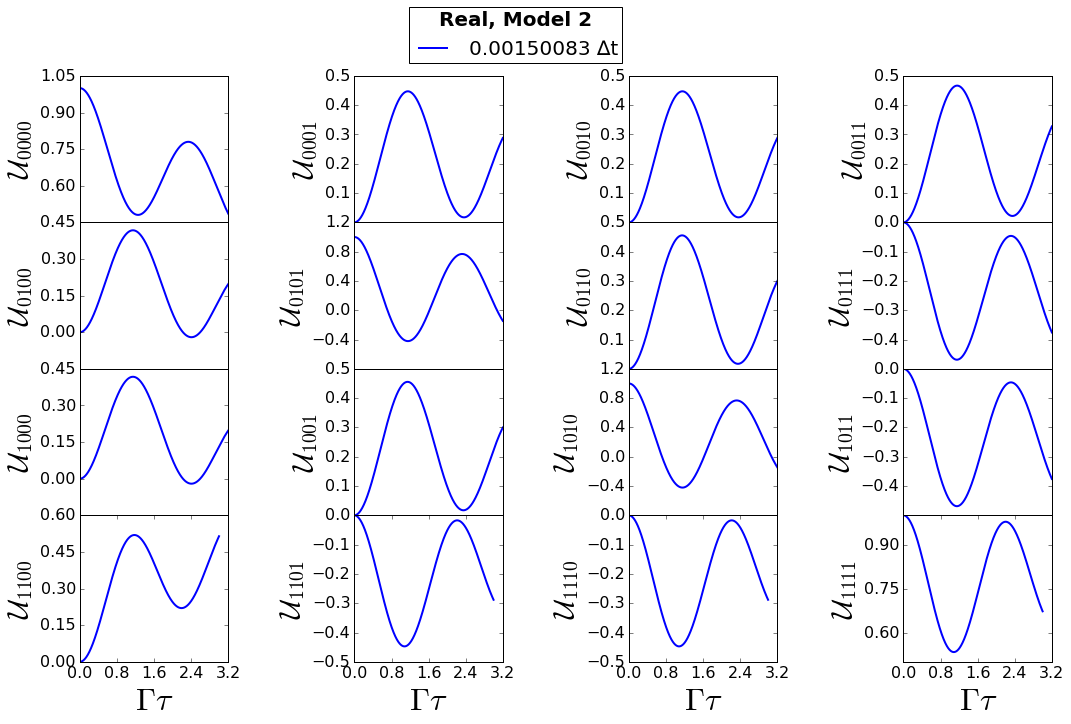

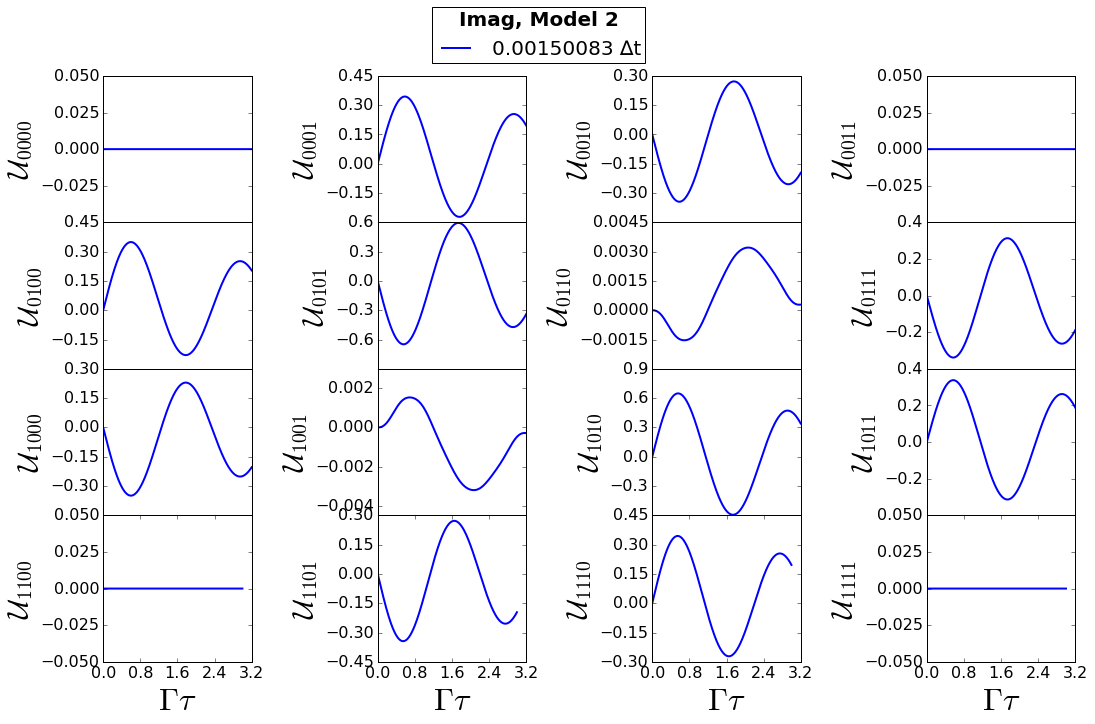

In [26]:
timeSteps = TIME_STEPS
graphStr = "%.8f ∆t"%DT

UTimeDict_file = {}
UDict_file = {}

U_file = np.zeros((timeSteps, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
time_file = np.zeros((timeSteps))

PARAM_STR = "_Spin-Boson_Ohmic_TT-TFD_b%sG%s_e%s_"%(BETA, GAMMA_DA, EPSILON)
PARAM_STR += "t%.8f_xi%swc%s_"%(DT, XI, OMEGA_C)
PARAM_STR += "wmax%s_dofn%s_tf%.4f"%(OMEGA_MAX, DOF_N, FINAL_TIME)

for j in range(DOF_E_SQ):
    a = int(j/DOF_E)
    b = int(j%DOF_E)
    for k in range(DOF_E_SQ):
        c = int(k/DOF_E)
        d = int(k%DOF_E)

        t, Ureal, Uimag = np.hsplit(
            np.loadtxt("U_Output/U_%s%s%s%s"%(a,b,c,d) + PARAM_STR
                        + ".txt"), 3)

        for l in range(timeSteps):
            time_file[l] = t[l]
            U_file[l][j][k] = Ureal[l] + 1.j * Uimag[l]

UTimeDict_file.update({"%s"%graphStr : time_file})
UDict_file.update({"%s"%graphStr : U_file})

legendPos_x = 0.8
legendPos_y = 1.
graph4x4("Real", MODEL_NUM, legendPos_x, legendPos_y, "U", graphStr,
         UTimeDict_file, UDict_file)
graph4x4("Imag", MODEL_NUM, legendPos_x, legendPos_y, "U", graphStr,
         UTimeDict_file, UDict_file)

# **2. Calculating the Projection-Free Inputs ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$**

$\quad$ As stated in Eqs. (12) and (13) [copied below], the projection-free inputs are related to numerical derivatives of the time evolution superoperator ${\cal U}(\tau)$:
$$F_{jk,lm}(\tau) = i\dot{\cal U}_{jk,lm}(\tau), \tag{12}$$
$$\dot{F}_{jk,lm}(\tau) = i\ddot{\cal U}_{jk,lm}(\tau). \tag{13}$$

$\quad$ In this section, we calculate the numerical derivatives for ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$ using the 2nd-order central difference method from [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html). This method calculates first ${\cal F}(\tau)$ as $i\dot{\cal U}_{jk,lm}(\tau)$ using the 2nd-order central difference method in the NumPy library. Then, $\dot{\cal F}(\tau)$ is calculated as $\dfrac{d}{d\tau} {\cal F}(\tau)$ using the same the 2nd-order central difference method.


## **2.1 Constants and Global Variables**##

In [27]:
### general constants ###
TIME_STEPS = 2000 # number of time steps
tau = 5           # propagation time step
au2ps = 0.00002418884254 # Conversion of attoseconds to atomic units
timeau = 12.409275
DT = tau * au2ps * timeau # time step in au
FINAL_TIME = TIME_STEPS * DT # final time
DOF_E = 2 # number of electronic states
DOF_E_SQ = DOF_E * DOF_E
DOF_N = 60 # number of nuclear DOF

### constants related to the model number ###
MODEL_NUM = 2 # model number

# setting parameters that based on the model number
BETA = 5 # inverse finite temperature
GAMMA_DA = 1 # diabatic coupling
if MODEL_NUM == 1:
    EPSILON = 1    # half of the energy gap between the donor and acceptor
    XI = 0.1       # friction coefficient, determines strength of e-n coupling
    OMEGA_C = 1    # cutoff frequency of the nuclear DOF
    OMEGA_MAX = 5  # maximum frequency of the nuclear DOF
elif MODEL_NUM == 2:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 3:
    EPSILON = 1
    XI = 0.1
    OMEGA_C = 7.5
    OMEGA_MAX = 36
elif MODEL_NUM == 4:
    EPSILON = 1
    XI = 0.4
    OMEGA_C = 2
    OMEGA_MAX = 10
elif MODEL_NUM == 6:
    EPSILON = 0
    XI = 0.2
    OMEGA_C = 2.5
    OMEGA_MAX = 12

### parameter string for file input/output ###
PARAM_STR = "_Spin-Boson_Ohmic_TT-TFD_b%sG%s_e%s_t%.8f_"%(BETA, GAMMA_DA, EPSILON, DT)
PARAM_STR += "xi%swc%s_wmax%s_dofn%s_tf%.4f"%(XI, OMEGA_C, OMEGA_MAX, DOF_N, FINAL_TIME)

### variables ###
time = np.zeros((TIME_STEPS))
U = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
F = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
Fdot = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

### printing parameters ###
print("     time steps =", TIME_STEPS)
print("             DT =", DT)
print("     final time =", FINAL_TIME)
print("        model # =", MODEL_NUM)
print("          DOF_E =", DOF_E)
print("          DOF_N =", DOF_N)
print("           beta =", BETA)
print("       gamma_da =", GAMMA_DA)
print("        epsilon =", EPSILON)
print("             xi =", XI)
print("        omega_c =", OMEGA_C)
print("      omega_max =", OMEGA_MAX)
print("   param string =", PARAM_STR)

     time steps = 2000
             DT = 0.0015008299950527925
     final time = 3.001659990105585
        model # = 2
          DOF_E = 2
          DOF_N = 60
           beta = 5
       gamma_da = 1
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
   param string = _Spin-Boson_Ohmic_TT-TFD_b5G1_e1_t0.00150083_xi0.1wc2_wmax10_dofn60_tf3.0017


## **2.2 Calling Time and ${\cal U}(\tau)$ Values From Files**

$\quad$ This subsection will pull in the values of time and the time evolution superoperator ${\cal U}(\tau)$ from files generated by the previous section.

In [28]:
for j in range(DOF_E_SQ):
    a = str(int(j/DOF_E))
    b = str(int(j%DOF_E))
    for k in range(DOF_E_SQ):
        c = str(int(k/DOF_E))
        d = str(int(k%DOF_E))

        # opens and reads the U file
        t, Ureal, Uimag = np.hsplit(
            np.loadtxt("U_Output/U_%s%s%s%s"%(a,b,c,d) + PARAM_STR
                           + ".txt"), 3)

        # stores values in variables and combines real and imag parts of U
        for i in range(TIME_STEPS):
            time[i] = t[i]
            U[i][j][k] = Ureal[i] + 1.j * Uimag[i]

## **2.3 Function to Print ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$**

$\quad$ This function prints files with three tab-separated columns: the time, the real part, and the imaginary part for each element of ${\cal F}(\tau)$ and $\dot{\cal F}(\tau)$ into the folder `ProjFree_Output`.

In [29]:
def printFFdot(abcdStr, timeFFdot, Freal, Fimag, Fdotreal, Fdotimag):

    # outfileStr for F
    outfileFStr = "ProjFree_Output/F_" + abcdStr + PARAM_STR + ".txt"

    # opens and writes F values to file
    f = open(outfileFStr, "w")
    for i in range(len(Freal)):
        f.write("%s\t%s\t%s\n"%(timeFFdot[i], Freal[i], Fimag[i]))
    f.close()

    # outfileStr for Fdot
    outfileFdotStr = "ProjFree_Output/Fdot_" + abcdStr + PARAM_STR + ".txt"

    # opens and writes Fdot values to file
    f = open(outfileFdotStr, "w")
    for i in range(len(Fdotreal)):
        f.write("%s\t%s\t%s\n"%(timeFFdot[i], Fdotreal[i], Fdotimag[i]))
    f.close()

## **2.4 2nd-Order Central Difference**

$\quad$ This section calculates first ${\cal F}(\tau)$ from $i\dot{\cal U}_{jk,lm}(\tau)$ using the 2nd-order central difference method in the numpy library. Then, $\dot{\cal F}(\tau)$ is calculated from $\dfrac{d}{d\tau} {\cal F}(\tau)$ using the same the second-order central difference method.

$\quad$ In the second-order central difference method,
$$f'(x_n) = \frac{1}{2} f(x_{n + 1}) - \frac{1}{2} f(x_{n - 1}).$$

In [30]:
for j in range(DOF_E_SQ):
    a = str(int(j/DOF_E)) # a index of PFI_{abcd}
    b = str(int(j%DOF_E)) # b index of PFI_{abcd}
    for k in range(DOF_E_SQ):
        c = str(int(k/DOF_E)) # c index of PFI_{abcd}
        d = str(int(k%DOF_E)) # d index of PFI_{abcd}

        # extracts real and imag parts of U element
        Ureal = np.zeros((TIME_STEPS))
        Uimag = np.zeros((TIME_STEPS))
        for i in range(TIME_STEPS):
            Ureal[i] = U[i][j][k].real
            Uimag[i] = U[i][j][k].imag

        # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
        Freal = -1. * np.gradient(Uimag.flatten(), DT, edge_order = 2)
        Fimag = np.gradient(Ureal.flatten(), DT, edge_order = 2)

        # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
        Fdotreal = np.gradient(Freal, DT)
        Fdotimag = np.gradient(Fimag, DT)

        # creates string of indices for the PFIs
        abcdStr = a + b + c + d

        # prints F and Fdot to files; function in Sec. 2.3
        printFFdot(abcdStr, time, Freal, Fimag, Fdotreal, Fdotimag)

## **2.5 Function to Pull in ${\cal F}(\tau)$ or $\dot{\cal F}(\tau)$ from Files**

$\quad$ This function pulls in ${\cal F}(\tau)$ or $\dot{\cal F}(\tau)$ from files, so they can be graphed without having to re-run the previous subsections.

In [31]:
def buildFFdotDict(FFdotStr, dt, timeSteps, timeDict, quantityDict):

    quantity = np.zeros((timeSteps, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
    time = np.zeros((timeSteps))
    for j in range(DOF_E_SQ):
        a = str(int(j/DOF_E))
        b = str(int(j%DOF_E))
        for k in range(DOF_E_SQ):
            c = str(int(k/DOF_E))
            d = str(int(k%DOF_E))

            t, quantityReal, quantityImag = np.hsplit(
                np.loadtxt("ProjFree_Output/" + FFdotStr
                           + "_%s%s%s%s"%(a,b,c,d) + PARAM_STR + ".txt"), 3)

            for i in range(timeSteps):
                time[i] = t[i]
                quantity[i][j][k] = quantityReal[i] + 1.j * quantityImag[i]

    timeDict.update({"%.8f ∆t"%dt : time})
    quantityDict.update({"%.8f ∆t"%dt : quantity})


## **2.6 Graphing ${\cal F}(\tau)$ for Each Method**

$\quad$ This subsection graphs ${\cal F}(\tau)$ in a $4 \times 4$ grid using the function in Sec. IV.ii, with the values pulled from files using the function in Sec. 2.5 and the constants specified in Sec. 2.1. This allows you to graph ${\cal F}(\tau)$ without having to run Secs. 2.2 - 2.4 directly beforehand. The graphs are then stored in the `Figures/F_Graphs` folder.

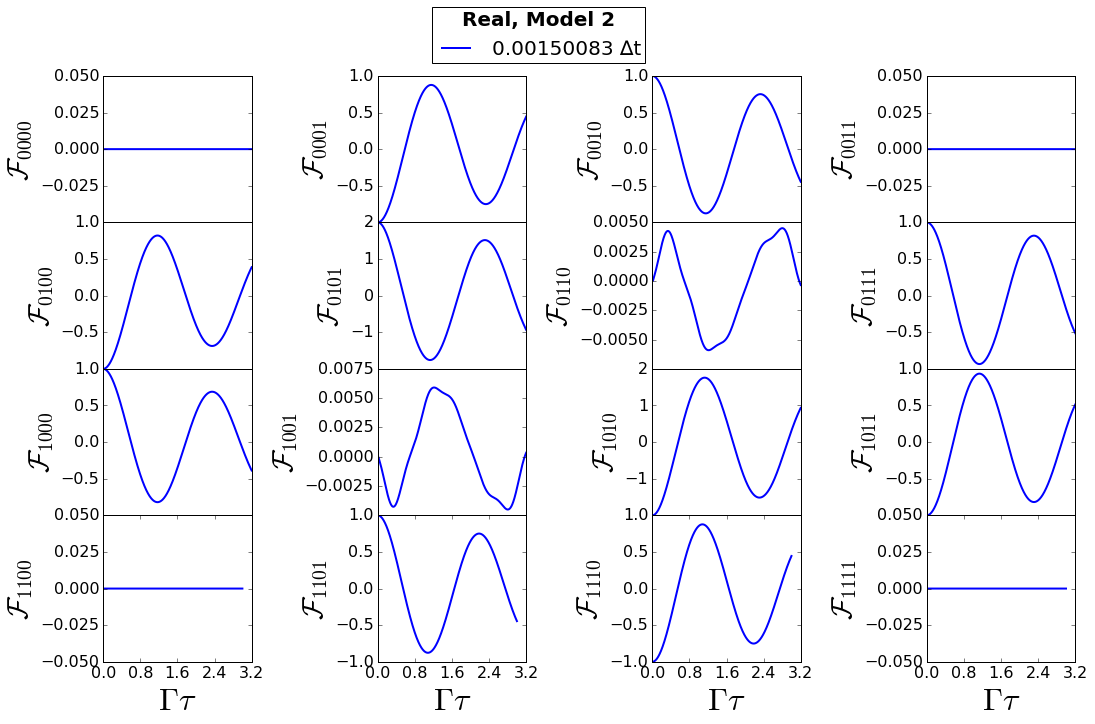

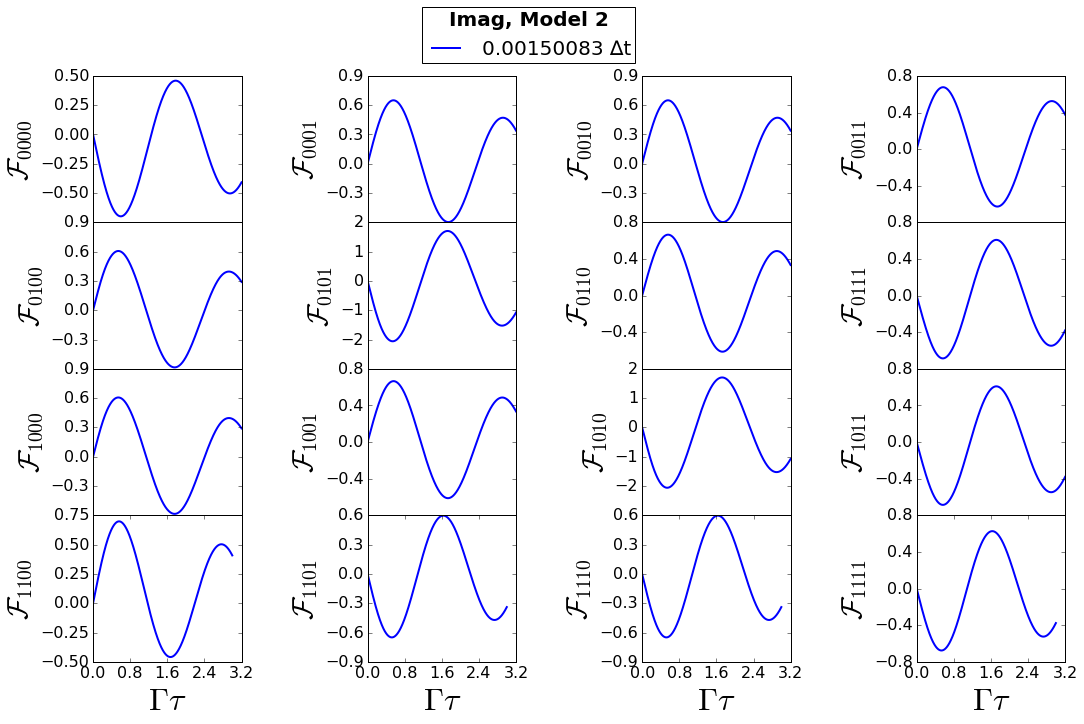

In [32]:
timeSteps = TIME_STEPS
F_TimeDict = {}
F_Dict = {}

buildFFdotDict("F", DT, timeSteps, F_TimeDict, F_Dict)

graphStr = "%.8f ∆t"%DT
legendPos_x = 0.8
legendPos_y = 1.
graph4x4("Real", MODEL_NUM, legendPos_x, legendPos_y, "F", graphStr, F_TimeDict,
         F_Dict)
graph4x4("Imag", MODEL_NUM, legendPos_x, legendPos_y, "F", graphStr, F_TimeDict,
         F_Dict)


## **2.7 Graphing $\dot{\cal F}(\tau)$ for Each Method**

$\quad$ This subsection graphs $\dot{\cal F}(\tau)$ in a $4 \times 4$ grid using the function in Sec. IV.ii, with the values pulled from files using the function in Sec. 2.5 and the constants specified in Sec. 2.1. This allows you to graph $\dot{\cal F}(\tau)$ without having to run Secs. 2.2 - 2.4 directly beforehand. The graphs are then stored in the `Figures/Fdot_Graphs` folder.

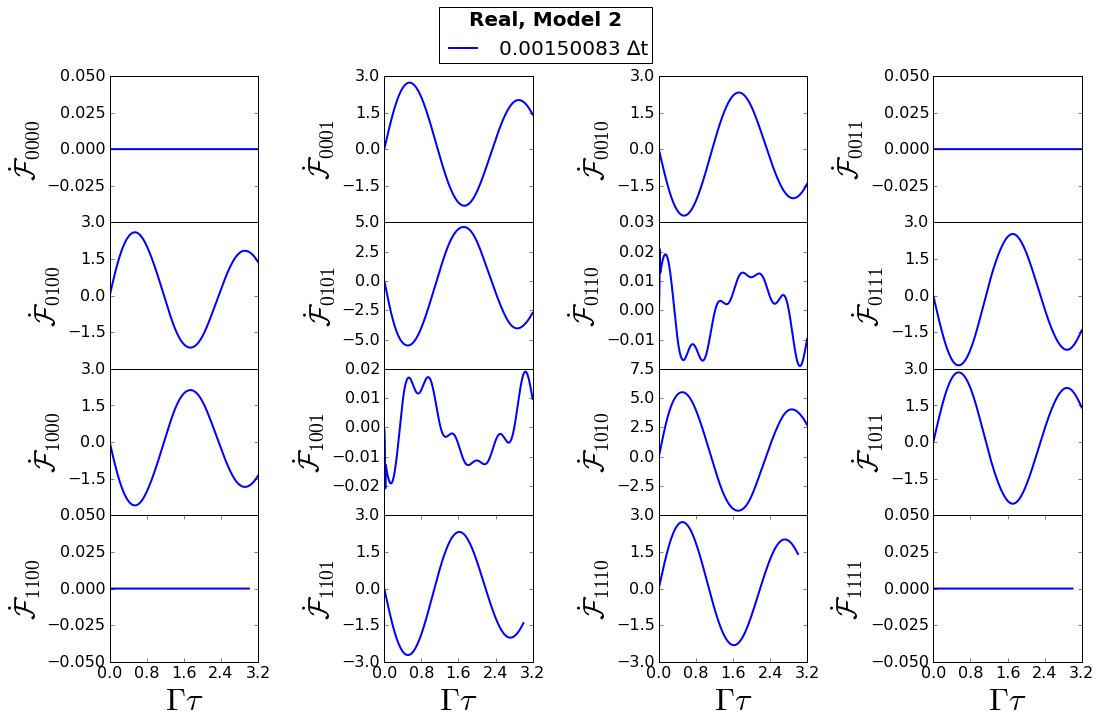

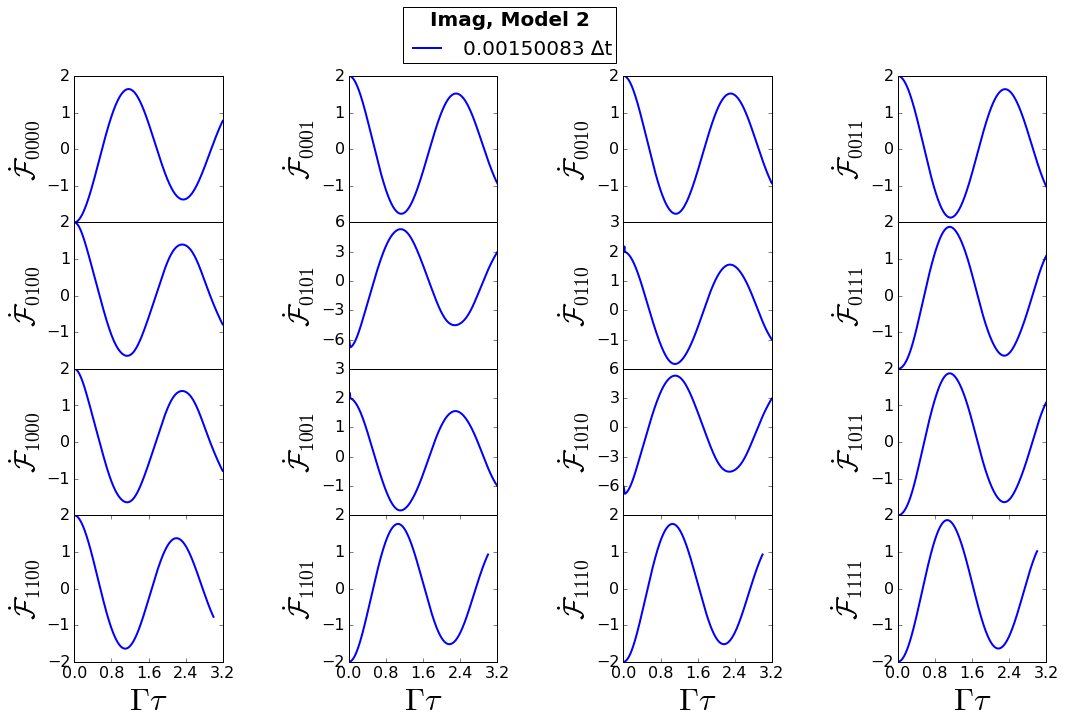

In [33]:
timeSteps = TIME_STEPS
Fdot_TimeDict = {}
Fdot_Dict = {}

buildFFdotDict("Fdot", DT, timeSteps, Fdot_TimeDict, Fdot_Dict)

graphStr = "%.8f ∆t"%DT
legendPos_x = 0.8
legendPos_y = 1.
graph4x4("Real", MODEL_NUM, legendPos_x, legendPos_y, "Fdot", graphStr,
         Fdot_TimeDict, Fdot_Dict)
graph4x4("Imag", MODEL_NUM, legendPos_x, legendPos_y, "Fdot", graphStr,
         Fdot_TimeDict, Fdot_Dict)